In [1]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from response import noisify
from tqdm import tqdm_notebook as tqdm
from adafilt import FastBlockLMSFilter, LMSFilter
from adafilt.io import FakeInterface
from adafilt.utils import lfilter, wgn

In [2]:
length = 16
stepsizes = np.logspace(-1, 0, 3)
navg = 100
snr = 20
# primary path impulse response
h_pri = [0, 0, 0, 0, 1]
# secondary path impulse response
h_sec = np.array([0, 0, 1])
nsamples = 1024

## LMSFilter

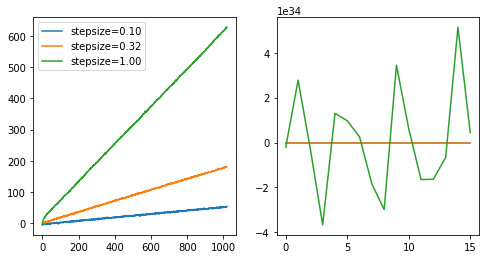

In [3]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for stepsize in tqdm(stepsizes):
    e = 0
    w = 0
    for i in range(navg):
        # reference signal
        x = np.random.normal(0, 1, nsamples)

        # desired signal with noise
        d = lfilter(h_pri, 1, x)
        dn = noisify(d, snr, unit="dB")

        filt = LMSFilter(length, stepsize=stepsize)

        y, _, ei, wi = filt(x[len(h_pri):], dn[len(h_pri):])
        
        e += 1/navg * 10 * np.log10(ei**2)
        w += 1/navg * wi
        
    ax[0].plot(e, label=f"stepsize={stepsize:.2f}")
    ax[1].plot(w[-1], label=f"stepsize={stepsize:.2f}")

ax[0].legend()

## LMSFilter with reference

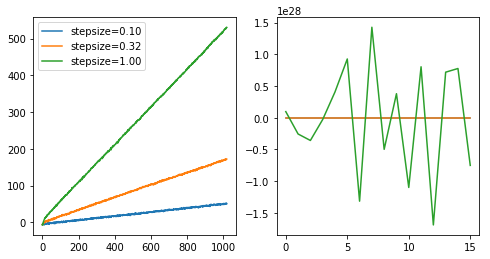

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for stepsize in tqdm(stepsizes):
    e = 0
    w = 0
    for i in range(navg):
        # reference signal
        x = np.random.normal(0, 1, nsamples)

        # desired signal with noise
        d = lfilter(h_pri, 1, x)
        dn = noisify(d, snr, unit="dB")

        filt = LMSFilter(length, stepsize=stepsize)

        y, u, ei, wi = filt(x[len(h_pri):], dn[len(h_pri):], h_sec, h_sec)
        
        e += 1/navg * 10 * np.log10(ei**2)
        w += 1/navg * wi
        
    ax[0].plot(e, label=f"stepsize={stepsize:.2f}")
    ax[1].plot(w[-1], label=f"stepsize={stepsize:.2f}")

ax[0].legend();

## FastBlockLMSFilter

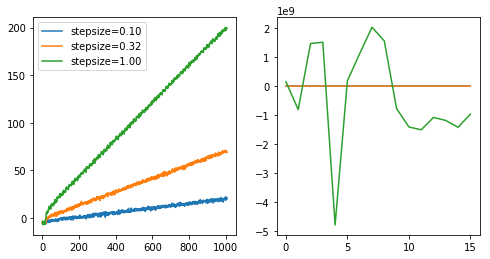

In [5]:
blocklength = length
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for stepsize in tqdm(stepsizes):
    e = 0
    w = 0
    for i in range(navg):
        # reference signal
        x = np.random.normal(0, 1, nsamples)

        # desired signal with noise
        d = lfilter(h_pri, 1, x)
        dn = noisify(d, snr, unit="dB")
        filt = FastBlockLMSFilter(blocklength, length, stepsize=stepsize)
        y, _, ei, wi = filt(x[blocklength:], dn[blocklength:])
        
        e += 1/navg * 10 * np.log10(ei**2)
        w += 1/navg * wi
        
    ax[0].plot(e, label=f"stepsize={stepsize:.2f}")
    ax[1].plot(w[-1], label=f"stepsize={stepsize:.2f}")

ax[0].legend();

## FastBlockLMSFilter with reference

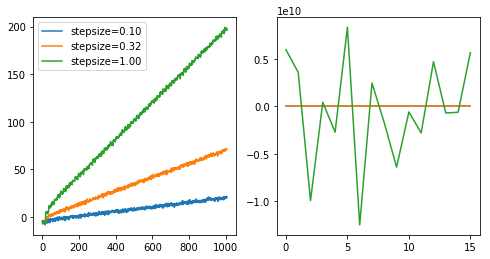

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for stepsize in tqdm(stepsizes):
    e = 0
    w = 0
    for i in range(navg):
        # reference signal
        x = np.random.normal(0, 1, nsamples)

        # desired signal with noise
        d = lfilter(h_pri, 1, x)
        dn = noisify(d, snr, unit="dB")
        filt = FastBlockLMSFilter(length, blocklength, stepsize=stepsize)
        y, _, ei, wi = filt(x[blocklength:], dn[blocklength:], h_sec, h_sec)
        
        e += 1/navg * 10 * np.log10(ei**2)
        w += 1/navg * wi
        
    ax[0].plot(e, label=f"stepsize={stepsize:.2f}")
    ax[1].plot(w[-1], label=f"stepsize={stepsize:.2f}")

ax[0].legend();

## FakeInterface

Test

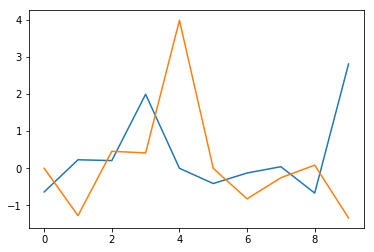

In [7]:
#np.random.seed(0)
buffsize = 1
buffers = 100
signal = np.random.normal(0, 1, size=buffers * buffsize * 2)
sim = FakeInterface(buffsize, signal, h_pri=[0, 1], h_sec=[1])

xs = []
es = []

x = np.array([0])
for i in range(10):
    x, e, u, d = sim.playrec(x)
    xs.append(x)
    es.append(e)

plt.plot(xs)
plt.plot(es)

Measure primary and secondary path

In [8]:
buffsize = 1
buffers = 1000
h_pri = [0, 1]
h_sec = [1]
sim = FakeInterface(
    buffsize,
    np.random.normal(0, 1, size=buffers * buffsize),
    h_pri=h_pri,
    h_sec=h_sec,
)

# measure primary path
xs = []
es = []
for i in range(buffers):
    x, e, _, _ = sim.rec()
    xs.append(x)
    es.append(e)
    
xs = np.concatenate(xs)
es = np.concatenate(es)
h_pri_meas = np.fft.irfft(np.fft.rfft(es) / np.fft.rfft(xs))[:10]

# measure secondary path
sim.reset()
ys = []
us = []
for i in range(buffers):
    y = np.random.normal(0, 1, size=buffsize)
    _, e, _, _ = sim.playrec(y, send_signal=False)
    ys.append(y)
    us.append(-e)

ys = np.concatenate(ys)
us = np.concatenate(us)
h_sec_meas = np.fft.irfft(np.fft.rfft(us) / np.fft.rfft(ys))[:10]

plt.plot(h_pri_meas, label="pri")
plt.plot(h_sec_meas, label="sec")
plt.legend()


AttributeError: 'NoneType' object has no attribute 'reshape'

### Sample based FxLMS

V1 usign adapt and filt

In [ ]:
np.set_printoptions(precision=2)
np.random.seed(0)

h_pri = np.zeros(1024)
h_pri[-1] = 1
h_sec = np.zeros(512)
h_sec[-1] = 1

blocklength = 128
length = 512

# random signal
Nbuffs = 400
signal = np.random.normal(0, 1, size=Nbuffs * blocklength)

filt = LMSFilter(length, stepsize=0.1)
sim = FakeInterface(blocklength, signal, h_pri=h_pri, h_sec=h_sec, noise=wgn(signal, 40, 'dB'))

# error and and filtered reference stepsizest have the same delay 
h_sec_model = np.concatenate((np.zeros(blocklength), h_sec)) 

xlog = []
elog = []
wslog = []
ylog = []

zisec = np.zeros(len(h_sec_model) - 1)
fxbuff = deque(np.zeros(length), maxlen=length)
xbuff = deque(np.zeros(length), maxlen=length)
y = np.zeros(blocklength)
for i in tqdm(range(Nbuffs)):
    
    x, e, u, d = sim.playrec(y)
    fx, zisec = lfilter(h_sec_model, 1, x, zi=zisec)
    for i in range(blocklength):
        filt.adapt(fx[i], e[i])
        y[i] = filt.filt(x[i])
    
    xlog.append(x)
    elog.append(e)
    ylog.append(y.copy())
    wslog.append(filt.w)
    
xlog = np.concatenate(xlog)
elog = np.concatenate(elog)
ylog = np.concatenate(ylog)

    
plt.plot(xlog, label="x")
plt.plot(ylog, label="y")
plt.plot(elog, label="e")
plt.legend()

plt.figure()
ax = plt.plot(wslog);
#plt.legend(ax, range(length))

plt.figure()
plt.plot(10*np.log10(np.array(elog)**2))


### FastBlockFxLMS sistepsizelation with variable block size

Some necessary conditions for convergence

In [ ]:
assert blocklength <= len(h_sec)
assert blocklength <= len(h_pri) - len(h_sec)
assert length > len(h_pri) - len(h_sec) - blocklength

#### Buffersize == filtersize

In [ ]:
blocklength = 512
length = 512

Nbuffs = 150
signal = np.random.normal(0, 1, size=Nbuffs * blocklength)

filt = FastBlockLMSFilter(blocklength, length, stepsize=0.1)
sim = FakeInterface(blocklength, signal, h_pri=h_pri, h_sec=h_sec, noise=wgn(signal, 40, 'dB'))

# error and and filtered reference stepsizest have the same delay 
h_sec_model = np.concatenate((np.zeros(blocklength), h_sec)) 

xlog = []
elog = []
wslog = []
ylog = []

zisec = np.zeros(len(h_sec_model) - 1)
y = np.zeros(blocklength)
for i in tqdm(range(Nbuffs)):
    
    x, e, u, d = sim.playrec(y)

    fx, zisec = lfilter(h_sec_model, 1, x, zi=zisec)
    
    # adapt filter
    filt.adapt(fx, e)

    # filter
    y = filt.filt(x)

    xlog.append(x)
    elog.append(e)
    ylog.append(y.copy())
    wslog.append(filt.w)
    
xlog = np.concatenate(xlog)
elog = np.concatenate(elog)
ylog = np.concatenate(ylog)
wslog = np.stack((wslog))

    
plt.plot(xlog, label="x")
plt.plot(ylog, label="y")
plt.plot(elog, label="e")
plt.legend()

plt.figure()
ax = plt.plot(wslog);
#plt.legend(ax, range(length))

plt.figure()
plt.plot(10*np.log10(np.array(elog)**2))


#### Buffersize < filtersize

In [ ]:
blocklength = 128
length = 512

Nbuffs = 150
signal = np.random.normal(0, 1, size=Nbuffs * blocklength)

filt = FastBlockLMSFilter(length, blocklength)
sim = FakeInterface(blocklength, signal, h_pri=h_pri, h_sec=h_sec, noise=wgn(signal, 40, 'dB'))

# error and and filtered reference stepsizest have the same delay 
h_sec_model = np.concatenate((np.zeros(blocklength), h_sec)) 

xlog = []
elog = []
wslog = []
ylog = []

zisec = np.zeros(len(h_sec_model) - 1)
y = np.zeros(blocklength)
for i in tqdm(range(Nbuffs)):
    
    x, e, u, d = sim.playrec(y)

    fx, zisec = lfilter(h_sec_model, 1, x, zi=zisec)
    
    # adapt filter
    filt.adapt(fx, e)

    # filter
    y = filt.filt(x)

    xlog.append(x)
    elog.append(e)
    ylog.append(y.copy())
    wslog.append(filt.w)
    
xlog = np.concatenate(xlog)
elog = np.concatenate(elog)
ylog = np.concatenate(ylog)
wslog = np.stack((wslog))

    
plt.plot(xlog, label="x")
plt.plot(ylog, label="y")
plt.plot(elog, label="e")
plt.legend()

plt.figure()
ax = plt.plot(wslog);
#plt.legend(ax, range(length))

plt.figure()
plt.plot(10*np.log10(np.array(elog)**2))


## Multi Channel

In [10]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from adafilt import MultiChannelBlockLMS, SimpleFilter
from adafilt.io import FakeInterface
from adafilt.utils import lfilter, wgn

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Develop adafilt.optimal

In [1]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2
import numpy as np
import adafilt as af
from scipy.signal import csd
from adafilt.utils import olafilt
from response import Response
import matplotlib.pyplot as plt

n = 1024
p = [1, 0, 1, 0]
g = [0, 1, 0, 0]
x = np.random.random(2**18)
d = olafilt(p, x)

In [2]:
nfft = None
if g is None:
    G = np.ones(n)
else:
    G = np.fft.fft(g, n=n)
if nfft is None:
    nfft = n

_, Sxd = csd(x, d, nperseg=n, return_onesided=False)
_, Sxx = csd(x, x, nperseg=n, return_onesided=False)

wopt = - Sxd / Sxx / G

c = np.ones(nfft)
c[nfft // 2:] = 0
# half at DC and Nyquist
c[0] = 0.5
if nfft % 2 == 0:
    c[nfft // 2] = 0.5

# minimum phase and allpass components of G
Gmin = np.exp(np.fft.fft(c * np.fft.ifft(2 * np.log(np.abs(G)), n=nfft), n=n))
Gall = G / Gmin

# spectral factor
F = np.exp(np.fft.fft(c * np.fft.ifft(np.log(Sxx), n=nfft), n=n))

h = np.ones(nfft)
h[nfft // 2:] = 0
woptcon = - np.fft.fft(h * np.fft.ifft(Sxd / F.conj() / Gall), n=n) / (F * Gmin)

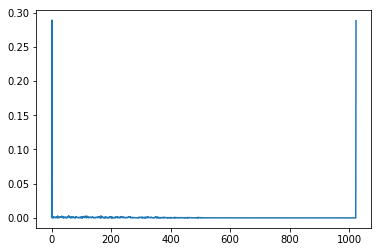

In [3]:
plt.plot(np.abs(np.fft.ifft(Sxd / F.conj() / Gall)))

minimum phase and allpass component

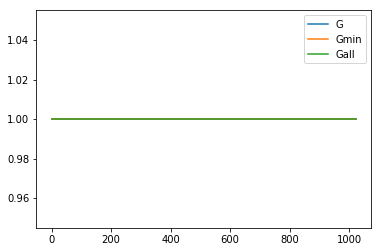

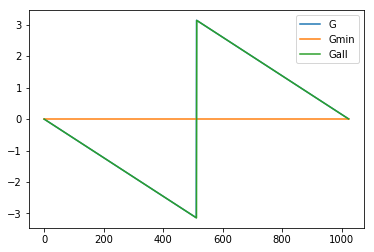

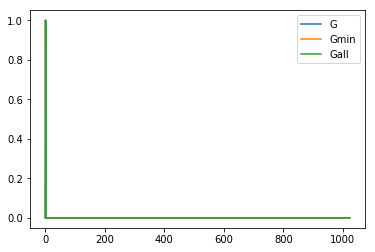

In [4]:
plt.plot(np.abs(G), label="G")
plt.plot(np.abs(Gmin), label=("Gmin"))
plt.plot(np.abs(Gall), label=("Gall"))
plt.legend()

plt.figure()
plt.plot(np.angle(G), label="G")
plt.plot(np.angle(Gmin), label=("Gmin"))
plt.plot(np.angle(Gall), label=("Gall"))
plt.legend()

plt.figure()
plt.plot(np.real(np.fft.ifft(G)), label="G")
plt.plot(np.real(np.fft.ifft(Gmin)), label=("Gmin"))
plt.plot(np.real(np.fft.ifft(Gall)), label=("Gall"))
plt.legend()


Spectral factors

True

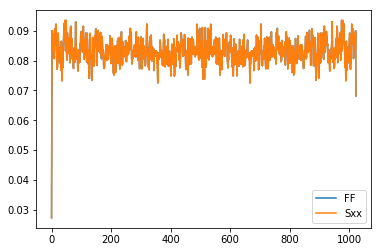

In [5]:
plt.plot(np.abs(F*F.conj()), label=("FF"))
plt.plot(np.abs(Sxx), label=("Sxx"))
plt.legend()

np.allclose(F*F.conj(), Sxx)

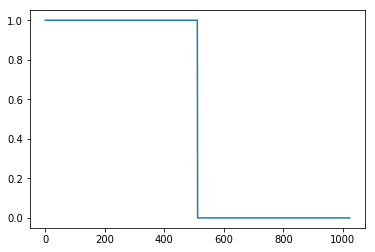

In [6]:
plt.plot(h)

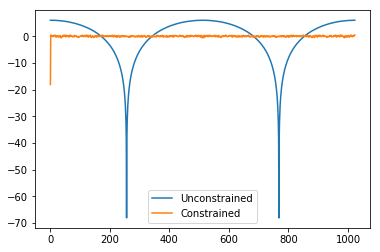

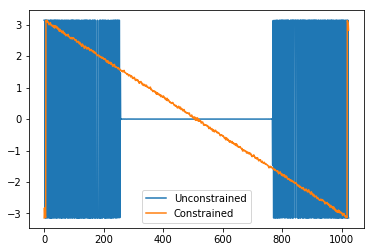

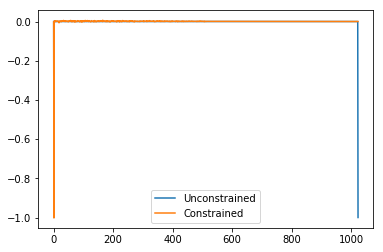

In [7]:
plt.plot(20 * np.log10(np.abs(wopt)), label="Unconstrained")
plt.plot(20 * np.log10(np.abs(woptcon)), label="Constrained")
plt.legend()

plt.figure()
plt.plot(np.angle(wopt), label="Unconstrained")
plt.plot(np.angle(woptcon), label="Constrained")
plt.legend()

plt.figure()
plt.plot(np.real(np.fft.ifft(wopt)), label="Unconstrained")
plt.plot(np.real(np.fft.ifft(woptcon)), label="Constrained")
plt.legend()

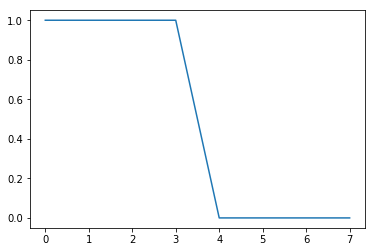

In [8]:
h = np.ones(8)
h[8 // 2:] = 0
plt.plot(h)

## Test 1d

Compare optimal wiener filter and multichannel optimal wiener filter.

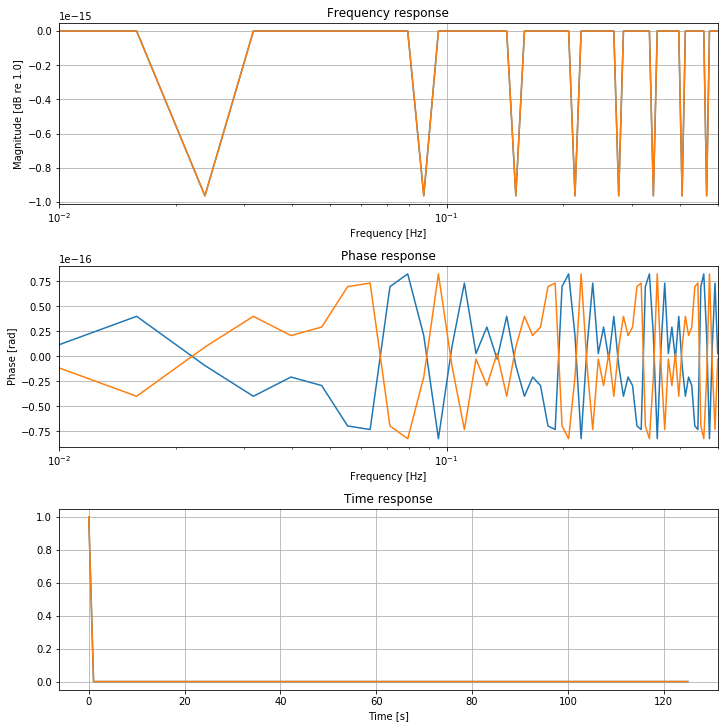

(True, True)

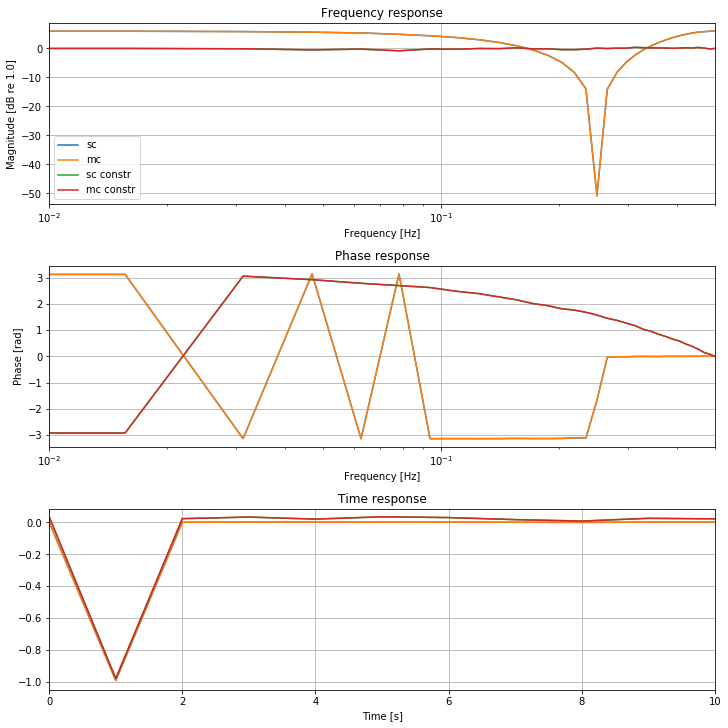

In [5]:
from adafilt.optimal import wiener_filter, multi_channel_wiener_filter, static_filter

n = 16
p = [1, 0, 1]
g = [0, 1, 0]
x = np.random.random(2**14)
d = olafilt(p, x)

nfilt = n * 4
wopt = wiener_filter(x, d, nfilt, g)
woptmc = multi_channel_wiener_filter(x, d, nfilt, g)
woptcon = wiener_filter(x, d, nfilt, g, constrained=True)
woptconmc = multi_channel_wiener_filter(x, d, nfilt, g, constrained=True)

fig = Response.from_freq(1, wopt[:nfilt // 2 + 1]).plot(label="sc")
Response.from_freq(1, woptmc[:nfilt // 2 + 1].T).plot(use_fig=fig, label="mc");
Response.from_freq(1, woptcon[:nfilt // 2 + 1]).plot(use_fig=fig, label="sc constr")
Response.from_freq(1, woptconmc[:nfilt // 2 + 1].T).plot(use_fig=fig, flim=(1e-2, 0.5), tlim=(0, 10), label="mc constr");

np.allclose(woptcon, woptconmc[:, 0, 0]), np.allclose(wopt, woptmc[:, 0, 0])

## Test 2d

/home/fhchl/dtuCloud/PhD/Subprojects/software/adafilt/adafilt/optimal.py:165: RuntimeWarning: divide by zero encountered in log
  Gmin = hermtrans(spectral_factor(hermtrans(G) @ G + rho * np.eye(Nout)))
/home/fhchl/dtuCloud/PhD/Subprojects/software/adafilt/adafilt/optimal.py:162: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.fft.fft(c * np.fft.ifft(np.log(x), axis=0), axis=0))
/home/fhchl/dtuCloud/PhD/Subprojects/software/adafilt/adafilt/optimal.py:162: RuntimeWarning: invalid value encountered in multiply
  return np.exp(np.fft.fft(c * np.fft.ifft(np.log(x), axis=0), axis=0))


[[[ 2.48490665e+00+0.j  2.48490665e+00+0.j]
  [ 2.48490665e+00+0.j  2.48490665e+00+0.j]]

 [[ 2.48430420e+00+0.j  2.48430420e+00+0.j]
  [ 2.48430420e+00+0.j  2.48430420e+00+0.j]]

 [[ 2.48249611e+00+0.j  2.48249611e+00+0.j]
  [ 2.48249611e+00+0.j  2.48249611e+00+0.j]]

 [[ 2.47948021e+00+0.j  2.47948021e+00+0.j]
  [ 2.47948021e+00+0.j  2.47948021e+00+0.j]]

 [[ 2.47525284e+00+0.j  2.47525284e+00+0.j]
  [ 2.47525284e+00+0.j  2.47525284e+00+0.j]]

 [[ 2.46980888e+00+0.j  2.46980888e+00+0.j]
  [ 2.46980888e+00+0.j  2.46980888e+00+0.j]]

 [[ 2.46314167e+00+0.j  2.46314167e+00+0.j]
  [ 2.46314167e+00+0.j  2.46314167e+00+0.j]]

 [[ 2.45524304e+00+0.j  2.45524304e+00+0.j]
  [ 2.45524304e+00+0.j  2.45524304e+00+0.j]]

 [[ 2.44610321e+00+0.j  2.44610321e+00+0.j]
  [ 2.44610321e+00+0.j  2.44610321e+00+0.j]]

 [[ 2.43571078e+00+0.j  2.43571078e+00+0.j]
  [ 2.43571078e+00+0.j  2.43571078e+00+0.j]]

 [[ 2.42405267e+00+0.j  2.42405267e+00+0.j]
  [ 2.42405267e+00+0.j  2.42405267e+00+0.j]]

 [[ 2.4111

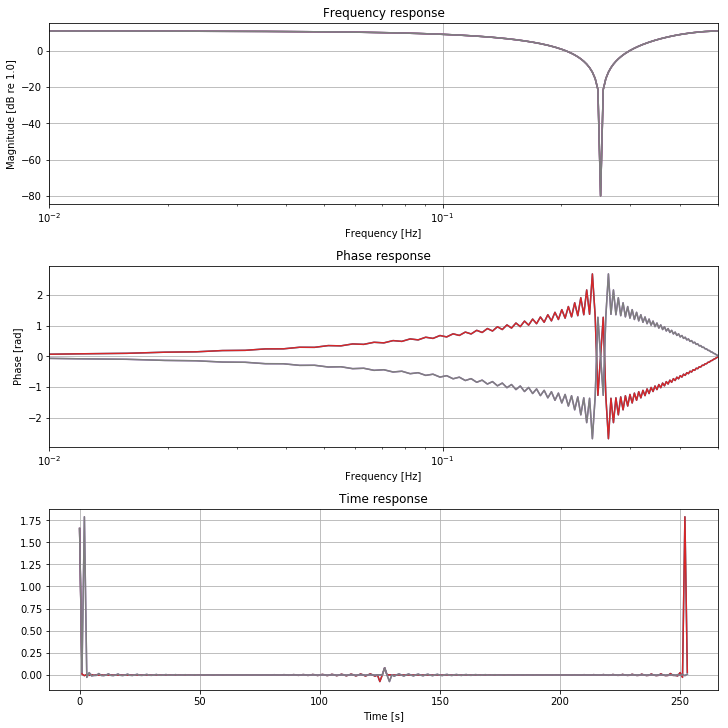

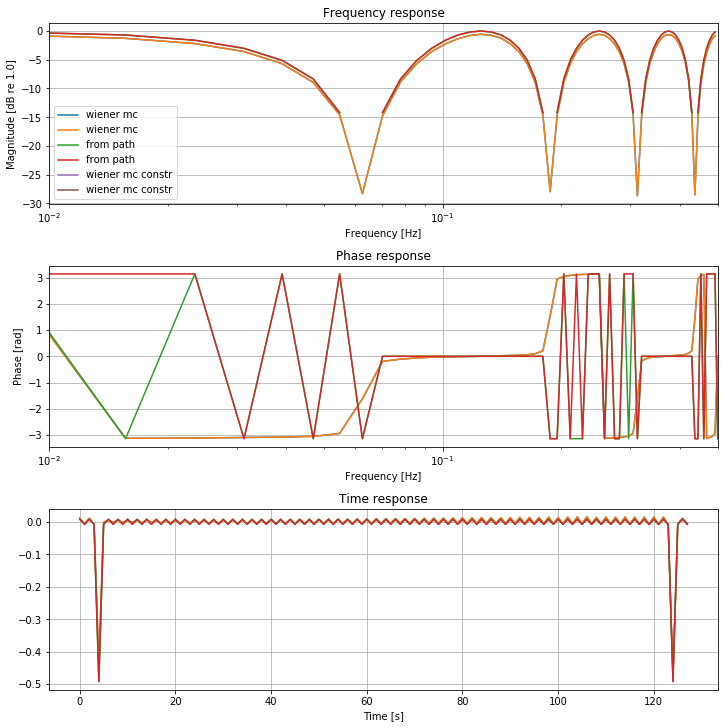

In [26]:
n = 32
Nin = 1
Nout = 2
Nmic = 3
# primary path
p = np.zeros((n, Nmic))
p[[8,9,  16, 17]] = 1

# secondary path
g = np.zeros((n, Nmic, Nout))
g[[12, 13]] = 1

# signal
x = np.random.normal(size=(2**18, Nin))
d = olafilt(p, x)

nfilt = 4 * n
Wsigcon = multi_channel_wiener_filter(x, d, nfilt, g, constrained=True, rho=1e-8)
Wsig = multi_channel_wiener_filter(x, d, nfilt, g, constrained=False)
Wpath = static_filter(p, g, nfilt)

fig = Response.from_freq(1, Wsig[:nfilt // 2 + 1].T).plot(label="wiener mc");
Response.from_freq(1, Wpath[:nfilt // 2 + 1].T).plot(use_fig=fig, label="from path");
Response.from_freq(1, Wsigcon[:nfilt // 2 + 1].T).plot(use_fig=fig, flim=(1e-2, 0.5), label="wiener mc constr");

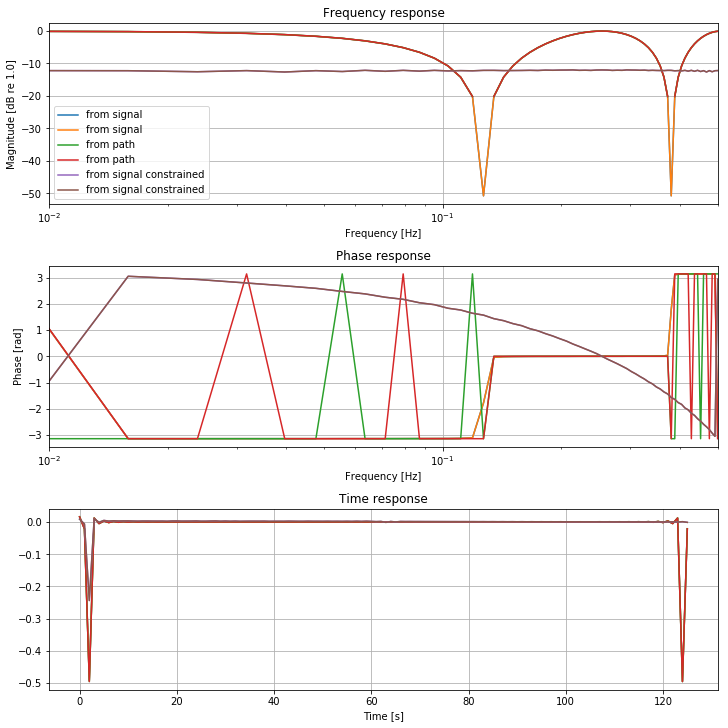

In [36]:
n = 16
Nin = 1
Nout = 2
Nmic = 3
# primary path
p = np.zeros((n, Nmic))
p[[0, 2]] = 1

# secondary path
g = np.zeros((n, Nmic, Nout))
g[1] = 1

# signal
x = np.random.normal(size=(2**18, Nin))
d = olafilt(p, x)

nfilt = 4 * n
Wsigcon = multi_channel_wiener_filter(x, d, nfilt, g, constrained=True)
Wsig = multi_channel_wiener_filter(x, d, nfilt, g, constrained=False)
Wpath = static_filter(p, g, nfilt)

fig = Response.from_freq(1, Wsig[:nfilt].T).plot(flim=(1e-2, 0.5), label="from signal");
Response.from_freq(1, Wpath[:nfilt].T).plot(use_fig=fig, flim=(1e-2, 0.5), label="from path");
Response.from_freq(1, Wsigcon[:nfilt].T).plot(use_fig=fig, flim=(1e-2, 0.5), label="from signal constrained");

# Develop adafilt.MultiChannelBlockLMS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from adafilt import MultiChannelBlockLMS
from adafilt.utils import olafilt
from adafilt.optimal import multi_channel_wiener_filter
from response import Response

n = 16
Nin = 1
Nout = 1
Nsens = 1
# primary path
h_pri = np.zeros((n, Nsens))
h_pri[0] = 1

# secondary path
h_sec = np.zeros((n, Nsens, Nout))
h_sec[0] = 1

# signal
x = np.random.normal(size=(2**18, Nin))
d = olafilt(h_pri, x)

nfilt = 4 * n
Wiener = multi_channel_wiener_filter(x, d, nfilt, h_sec, constrained=False)

Response.from_freq(1, Wiener[:nfilt+1].T).plot(flim=(1e-2, 0.5));

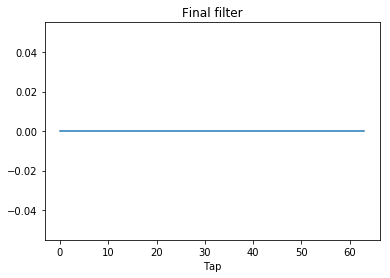

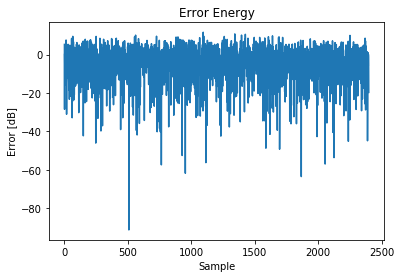

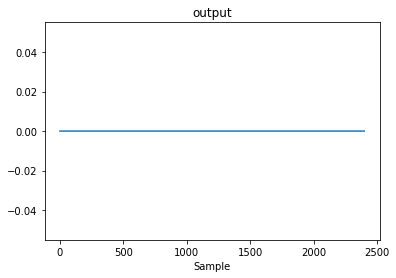

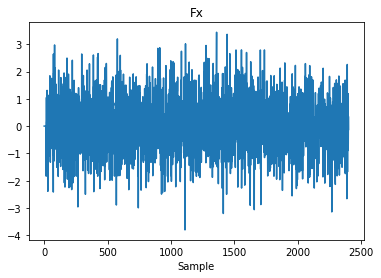

In [8]:
from adafilt import SimpleFilter

blocklength = n  # length of I/O buffer and blocksize of filter
n_buffers = 150  # size of simulation

# white noise signal
signal = np.random.normal(0, 1, size=n_buffers * blocklength)

# the adaptive filter
filt = MultiChannelBlockLMS(
    Nout=Nout,
    Nin=Nin,
    Nsens=Nsens,
    length=nfilt,
    blocklength=blocklength,
)

# secondary path estimate has to account for block size
primary_path = SimpleFilter(h_pri, squeeze=False)
secondary_path = SimpleFilter(h_sec, squeeze=False)
plant_model = SimpleFilter(np.concatenate((np.zeros((blocklength, 1, 1)), h_sec)), sum_inputs=False, squeeze=False)

# aggregate signals during simulation
xlog = []
elog = []
wslog = []
ylog = []
fxlog = []

y = np.zeros((blocklength, Nout))  # control signal is zero for first block
for i in range(n_buffers):

    x = np.random.normal(size=(blocklength, Nin))
    d = primary_path(x)
    u = secondary_path(y)
    e = d - u

    # filter the reference signal
    fx = plant_model(x)

    # adapt filter
    filt.adapt(fx, e)

    # filter
    y = filt.filt(x)

    xlog.append(x)
    elog.append(e)
    fxlog.append(fx)
    ylog.append(y.copy())
    wslog.append(filt.w)

plt.title("Final filter")
plt.plot(filt.w.reshape(nfilt, -1))
plt.xlabel("Tap")

plt.figure()
plt.title("Error Energy")
plt.plot(10 * np.log10(np.array(np.concatenate(elog)) ** 2))
plt.xlabel("Sample")
plt.ylabel("Error [dB]")

plt.figure()
plt.title("output")
plt.plot(np.concatenate(ylog))
plt.xlabel("Sample")

plt.figure()
plt.title("Fx")
plt.plot(np.concatenate(fxlog).reshape(blocklength * n_buffers, -1))
plt.xlabel("Sample")

plt.show()

In [113]:
%debug

> /home/fhchl/dtuCloud/PhD/Subprojects/software/adafilt/adafilt/__init__.py(531)adapt()
    529         E = np.fft.fft(
    530             np.concatenate(
--> 531                 (np.zeros((self.length, self.Nsens)), np.concatenate(self.eadaptbuff))
    532             )
    533         )

ipdb> [x.shape for x in self.eadaptbuff]
[(16, 1), (16, 1), (16, 1), (16,)]
ipdb> e.shape
(16,)
--KeyboardInterrupt--
ipdb> q


In [89]:

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14, 8), constrained_layout=True)

ax[0, 0].set_title("Signals")
ax[0, 0].plot(np.concatenate(xlog), label="x", alpha=1)
ax[0, 0].plot(np.concatenate(ylog), label="y", alpha=0.8)
ax[0, 0].plot(np.concatenate(elog), label="e", alpha=0.7)
ax[0, 0].set_xlabel("Sample")
ax[0, 0].legend()

ax[0, 1].set_title("Filter weights")
ax[0, 1].plot(wslog)
ax[0, 1].set_xlabel("Block")


ax[1, 0].set_title("Error Energy")
ax[1, 0].plot(10 * np.log10(np.array(np.concatenate(elog)) ** 2))
ax[1, 0].set_xlabel("Sample")
ax[1, 0].set_ylabel("Error [dB]")


ax[1, 1].set_title("Final filter")
ax[1, 1].plot(filt.w)
ax[1, 1].set_xlabel("Tap")

plt.show()

> /home/fhchl/dtuCloud/PhD/Subprojects/software/adafilt/adafilt/utils.py(110)olafilt()
    108     if zi is not None:
    109         zi = atleast_2d(zi)
--> 110         res[: zi.shape[0]] = res[: zi.shape[0]] + zi
    111         y = res[:L_sig]
    112         zf = res[L_sig : L_sig + L_I - 1]

ipdb> u
> /home/fhchl/dtuCloud/PhD/Subprojects/software/adafilt/adafilt/__init__.py(499)filt()
    497         x = atleast_2d(x)
    498         assert x.shape[0] == self.blocklength
--> 499         y, self.zifilt = olafilt(self.w, x, zi=self.zifilt, squeeze=False)
    500         return y
    501 

ipdb> self.zifilt.shape
(127, 1, 1, 1)
ipdb> d
> /home/fhchl/dtuCloud/PhD/Subprojects/software/adafilt/adafilt/utils.py(110)olafilt()
    108     if zi is not None:
    109         zi = atleast_2d(zi)
--> 110         res[: zi.shape[0]] = res[: zi.shape[0]] + zi
    111         y = res[:L_sig]
    112         zf = res[L_sig : L_sig + L_I - 1]

ipdb> zi.shape
(127, 1, 1, 1)
ipdb> res.shape
(144, 3)
i